# 2019 Inside Airbnb Data

## Packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_samples, silhouette_score

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
# These are specific to NLP
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()
mms  = MinMaxScaler(feature_range=(-1,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

## Standardiser

In [3]:
mms  = MinMaxScaler(feature_range=(-1,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

## Customised Functions

### Plotting Function

In [4]:
# This is the plotting function Jon wrote

def plt_ldn(w, b):
    """
    Creates a new figure of a standard size with the 
    water (w) and boundary (b) layers set up for easy
    plotting. Right now this function assumes that you're
    looking at London, but you could parameterise it in
    other ways or allow it to work for other areas.
    
    w: a water layer for London
    b: a borough (or other) boundary layer for London
    """
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

########################
# These may no longer be relevant because of changes to geopandas API

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

### Caching Function

In [5]:
import os
from requests import get
from urllib.parse import urlparse

# This is the cache function Jon wrote
def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    # os.path.getsize() gets the size of the file
    # if it doesn't exist, its size is less than 1
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## Import Raw Airbnb Data and Convert Data types

This section will focus on cleaning raw airbnb data from 2019.

By the end of this section, we will get a new dataframe which only contains columns that we are interested in.

In [6]:
# read in 2019 airbnb raw data
airbnb_raw = pd.read_csv('London-2019-listings.csv.gz', compression='gzip', low_memory=False)
print(f"Data frame is {airbnb_raw.shape[0]:,} x {airbnb_raw.shape[1]}")

Data frame is 85,068 x 106


### Import Images

In [7]:
# some shapefiles
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
water = gpd.read_file( cache_data(spath+'Water.gpkg?raw=true', ddir) )
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )
green = gpd.read_file( cache_data(spath+'Greenspace.gpkg?raw=true', ddir) )

Found data/geo/Water.gpkg locally!
Found data/geo/Boroughs.gpkg locally!
Found data/geo/Greenspace.gpkg locally!


In [8]:
# boros
boros.head(n=1)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry
0,Kingston upon Thames,E09000021,"3,726.12",0.00,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."


### General Data Cleaning: Booleans, Dates, Categories, Price Strings, Geography
**Most of this code comes from practical 5**

**In this section, I clean the entire dataset before selecting specific columns. This is for the purpose of reproducibility; individuals can select other fields in the Inside Airbnb dataset to expand upon this analysis.**

In [9]:
# Here I am parametrising the data by defining the columns so I can work with them more easily. 
# This comes from the FSDS practical 5.
cols = ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 
        'host_since', 'host_location', 'host_about', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 
        'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 
        'first_review', 'last_review', 'review_scores_rating', 'license', 'reviews_per_month', 'has_availability', 'calendar_last_scraped']

### Boolean

In [10]:
# columns that seem to have values that should be booleans
bcols = ['instant_bookable', 'host_has_profile_pic', 'host_identity_verified','host_is_superhost', 'has_availability']

In [11]:
# I want to make the dataset more usable and storable so I'll convert certain columns to booleans
for b in bcols:
    print(f"Converting {b}")
    airbnb_raw[b] = airbnb_raw[b].replace({'f':False, 't':True}).astype('bool')

Converting instant_bookable
Converting host_has_profile_pic
Converting host_identity_verified
Converting host_is_superhost
Converting has_availability


In [12]:
shm = airbnb_raw.host_is_superhost.memory_usage(deep=True) # Super Host Memory
bhm = airbnb_raw.host_is_superhost.replace({'f':False, 't':True}).astype('bool').memory_usage(deep=True) # Boolean Host Memory

print(f"The raw memory usage of `host_is_superhost` is {shm/1000:,.0f} Kb.")
print(f"The boolean memory usage of `host_is_superhost` is {bhm/1000:,.0f} Kb.")
print(f"That's {(bhm/shm)*100:.0f}% of the original!")

The raw memory usage of `host_is_superhost` is 85 Kb.
The boolean memory usage of `host_is_superhost` is 85 Kb.
That's 100% of the original!


### Date

In [13]:
dates = ['last_scraped','host_since', 'calendar_last_scraped','first_review','last_review']
airbnb_raw.sample(5, random_state=43)[dates]

,last_scraped,host_since,calendar_last_scraped,first_review,last_review
8497,2019-11-06,2015-05-31,2019-11-06,2016-05-16,2019-11-02
45100,2019-11-06,2016-02-15,2019-11-06,2018-07-22,2019-10-09
6408,2019-11-06,2014-07-19,2019-11-06,2015-06-01,2019-10-20
42897,2019-11-06,2011-02-12,2019-11-06,2018-04-11,2019-09-14
67011,2019-11-06,2018-04-17,2019-11-06,2019-06-22,2019-11-03


In [14]:
for d in dates:
    print("Converting " + d)
    airbnb_raw[d] = pd.to_datetime(airbnb_raw[d], infer_datetime_format=True)

Converting last_scraped
Converting host_since
Converting calendar_last_scraped
Converting first_review
Converting last_review


In [15]:
# This checks that we successfully changed the dates for each
for d in dates:
    print(airbnb_raw[d].dtype, "\n")
    print(airbnb_raw.sample(5, random_state=45)[d].dt.strftime('%A %B %d, %Y'))

datetime64[ns] 

20349    Wednesday November 06, 2019
66703    Wednesday November 06, 2019
52739    Wednesday November 06, 2019
52839    Wednesday November 06, 2019
77604    Wednesday November 06, 2019
Name: last_scraped, dtype: object
datetime64[ns] 

20349    Saturday March 28, 2015
66703     Thursday July 19, 2012
52739        Sunday May 19, 2013
52839    Tuesday August 25, 2015
77604    Tuesday August 27, 2019
Name: host_since, dtype: object
datetime64[ns] 

20349    Wednesday November 06, 2019
66703    Wednesday November 06, 2019
52739    Wednesday November 06, 2019
52839    Wednesday November 06, 2019
77604    Wednesday November 06, 2019
Name: calendar_last_scraped, dtype: object
datetime64[ns] 

20349       Sunday August 07, 2016
66703      Friday October 25, 2019
52739    Saturday October 26, 2019
52839    Friday September 21, 2018
77604    Monday September 16, 2019
Name: first_review, dtype: object
datetime64[ns] 

20349    Wednesday September 25, 2019
66703         Friday Oct

### Category

In [16]:
# converting to categories, here I am selecting the columns that use categorical data so we can groupby better
cats = ['property_type','room_type', 'host_location', 'host_response_time', 'host_location', 'neighbourhood_cleansed']
airbnb_raw.sample(5, random_state=42)[cats]

,property_type,room_type,host_location,host_response_time,host_location,neighbourhood_cleansed
2605,Townhouse,Private room,"London, England, United Kingdom",within a few hours,"London, England, United Kingdom",Hackney
47658,Condominium,Private room,"London, England, United Kingdom",NaN,"London, England, United Kingdom",Southwark
74026,Condominium,Entire home/apt,"London, England, United Kingdom",within an hour,"London, England, United Kingdom",Kensington and Chelsea
49113,Apartment,Entire home/apt,"England, United Kingdom",within a few hours,"England, United Kingdom",Greenwich
34438,House,Private room,"England, United Kingdom",within an hour,"England, United Kingdom",Croydon


In [17]:
for c in cats:
    print(f"Converting {c}")
    airbnb_raw[c] = airbnb_raw[c].astype('category')

Converting property_type
Converting room_type
Converting host_location
Converting host_response_time
Converting host_location
Converting neighbourhood_cleansed


### Price and String Values

In [18]:
money = ['price']

# part of the issue here was that you had to remove the commas as well 
# because it wouldn't convert to a float if you just removed the $
for m in money:
    print(f"Converting {m}")
    airbnb_raw[m] = airbnb_raw[m].str.replace('$','', 
                                              regex=False).str.replace(',','', 
                                                                       regex=False).astype('float')


Converting price


In [19]:
print(airbnb_raw.price.dtype)

float64


In [20]:
print(len(airbnb_raw[airbnb_raw['price'] == 0]))

18


In [21]:
priceis0 = (airbnb_raw[airbnb_raw['price'] == 0])
priceis0.head(18)[['id','name','price','neighbourhood_cleansed']]

,id,name,price,neighbourhood_cleansed
21196,14352218,Bedroom for 2 in huge 3000sqf+ Hackney warehouse,0.00,Hackney
28785,18373061,"Cosy loft with ensuite in relaxed, family home",0.00,Waltham Forest
29276,18607614,Double Bedroom in Primrose Hill,0.00,Camden
31438,19551457,Charming single room,0.00,Tower Hamlets
33744,20305863,"Apartments 'Luxury', Ealing",0.00,Ealing
33787,20274559,Central London Oxford Street room with Balcony,0.00,Westminster
34275,20513280,Funky Studio Apartment near Trendy Shoreditch,0.00,Tower Hamlets
34327,20568208,"Modern, spacious top floor double bedroom",0.00,Tower Hamlets
34336,20601806,Victoria Magical Atmosphere with 2 Patios,0.00,Westminster
34380,20606819,#3. SLEEP 4 - Aldgate - 10min Tower of London,0.00,Tower Hamlets


### Converting other Values to Pandas Integers

In [22]:
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'beds','minimum_nights','maximum_nights','availability_365']
for i in ints:
    print(f"Converting {i}")
    try:
        airbnb_raw[i] = airbnb_raw[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converting to unsigned 16-bit integer!!!")
        airbnb_raw[i] = airbnb_raw[i].astype('float').astype(pd.UInt16Dtype())

Converting id
Converting host_id
Converting host_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting host_total_listings_count
  - !!!Converting to unsigned 16-bit integer!!!
Converting accommodates
Converting beds
  - !!!Converting to unsigned 16-bit integer!!!
Converting minimum_nights
Converting maximum_nights
Converting availability_365


### Create a new DataFrame

This dataframe will be used for analysis which contains columns that we need!

In [23]:
fcols = ['id', 'name', 'description', 'host_id', 'host_location',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'property_type', 'room_type', 'minimum_nights',
       'maximum_nights', 'neighbourhood_cleansed', 'price']

In [24]:
airbnb = airbnb_raw[fcols]
print(f"Data frame is {airbnb.shape[0]:,} x {airbnb.shape[1]}")

Data frame is 85,068 x 15


## Data Cleaning

In [25]:
# create a column of geometry

gdf = gpd.GeoDataFrame(airbnb, geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude))

In [26]:
# set aribnb crs
gdf.set_crs(epsg=4326, inplace=True)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
# reproject airbnb crs
gdf = gdf.to_crs(epsg=27700)
gdf.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [28]:
gdf.head(n=3)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,latitude,longitude,property_type,room_type,minimum_nights,maximum_nights,neighbourhood_cleansed,price,geometry
0,11551,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,43039,"London, England, United Kingdom",3,3,51.46,-0.12,Apartment,Entire home/apt,3,180,Lambeth,88.00,POINT (530885.122 175377.940)
1,38151,Double room/ lounge,"Comfortable, large double room /lounge area av...",163634,GB,1,1,51.42,-0.09,Apartment,Private room,1,730,Croydon,65.00,POINT (533100.397 170667.128)
2,13913,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,54730,"London, England, United Kingdom",4,4,51.57,-0.11,Apartment,Private room,1,29,Islington,65.00,POINT (531005.968 187150.843)


In [29]:
gdf.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['id', 'name', 'description', 'host_id', 'host_location',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'property_type', 'room_type', 'minimum_nights',
       'maximum_nights', 'neighbourhood_cleansed', 'price', 'geometry'],
      dtype='object')>

In [30]:
gdf.rename(columns = {'neighbourhood_cleansed':'borough'}, inplace = True)

In [31]:
# merge airbnb and borough shapefile 
boro_listings = gpd.sjoin(gdf, boros.drop(
                        columns=['HECTARES', 'NONLD_AREA', 'ONS_INNER']), predicate='within'
                         ).drop(columns = ['latitude', 'longitude', 'index_right'])

In [32]:
# check merged data
boro_listings.head(n=3)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,property_type,room_type,minimum_nights,maximum_nights,borough,price,geometry,NAME,GSS_CODE
0,11551,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,43039,"London, England, United Kingdom",3,3,Apartment,Entire home/apt,3,180,Lambeth,88.00,POINT (530885.122 175377.940),Lambeth,E09000022
16,93500,LUXURY DOUBLE ROOM CLAPHAM(ZONE 2),Contemporary and stylish double bed room in th...,501399,"London, England, United Kingdom",1,1,Apartment,Private room,2,1125,Lambeth,54.00,POINT (530228.102 175601.447),Lambeth,E09000022
26,96008,Light airy double bedroom for rent,"We're set back from the road, with gardens - y...",510424,"London, England, United Kingdom",2,2,Apartment,Private room,2,365,Lambeth,80.00,POINT (531862.048 172841.560),Lambeth,E09000022


## Data Exploration

### Listings with Words Tied to Gentrification & Hotels/Hostels
**This code draws from practical 7. Here, I target descriptions using text mining analysis with the aim of discerning Airbnb listings that might be tied to gentrification. The main purpose of this section is to identify on a map where listings that buy into narratives surrounding gentrification are located.**

**Because I am working on NLP, I will drop all the description rows that have null values because I will primarily be working with the descriptions.**

In [33]:
gdf1 = boro_listings.dropna(subset=['description'])
print(f"Now gdf has {gdf.shape[0]:,} rows and {gdf.shape[1]:,} columns")

Now gdf has 85,068 rows and 16 columns


In [34]:
gdf1[~gdf1.description.isna()].description.sample(10, random_state=42)
#It seems there are more or less the same issues as in the practical regarding the descriptions

18299    Newly renovated flat and located on a beautifu...
15624    An award winning, very comfortable flat in qui...
18280    Peace and quiet right in the heart of East Lon...
33925    A flat with 2 double beds only a few minutes w...
55527    The flat is located in a former church hall bu...
38738    Professionally managed one bedroom apartment i...
21567    This is a 3 bedroom appartament with no living...
84775    Spacious 4 double bedroom, 2 bathroom, 4 beds ...
10200    Three fully furnished spacious bedrooms (2 dou...
6644     Located in popular Fulham area, my home is com...
Name: description, dtype: object

In [35]:
gdf1.description.iloc[56440]
#While many of the above end in ..., the dots do not appear to be part of the actual description but rather a way of shortening it

'Top floor flat share with great light throughout the day and surrounded by gardens. The bedroom includes a corner study with views to the garden. You will be sharing the flat with 2 lovely people. Access to the bathroom, kitchen and living room is shared. There is a piano and a 50" TV in the living room. Happy to send extra pictures upon request :) The area has some of the best transport links in London; underground to Oxford Street in 12 minutes, direct trains to Gatwick and Luton Airports. 5 minutes from the tube, overground and 3 minutes from Thameslink trains to Gatwick, Luton and Central London!'

In [36]:
#remove html
for col in gdf1.select_dtypes(include='object'):
    gdf1['description'] = gdf1['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

/opt/conda/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [37]:
#remove punctuation
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;\+\–\—]+')
punkt   = []
for l in gdf1['description']:
    punkt.append(re.sub(pattern, ' ', l))

Below, I am using the package 'textual' written for practical 7 that should do more or less the same thing as above. However, it will go further to remove stopwords, words with accents, special characters, digits, as well as lemmatise the text. This *could* double count some of the lower case, removal of punct and html that I've already done OR it could just be sure it worked. But, I think it's important to have done that above because it ended up catching more listings (about 100) than without the NLP.

In [38]:
#Regex for words often associated with gentrification:
gent = gdf1[gdf1.description.str.contains(
    r'\b(?:trend(?:y|iness|ing)|revitalize|popular(?:ity|ness)|edgy|vibrant|authentic(?:ity)|cultur(?:e|al|ed))\b', 
                                        regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {gent.shape[0]:,} records for airbnbs in areas that might be gentrifying")

Found 10,485 records for airbnbs in areas that might be gentrifying


In [39]:
# #Regex for words often associated with hotels/hostels:
# hotels = gd2f[gdf2.description.str.contains( r'\b(?:hotel|hostel)\b', regex=True, flags=re.IGNORECASE)].copy()
# print(f"Found {hotels.shape[0]:,} records for airbnbs in areas that might be hotels or hostels")

In [40]:
%load_ext autoreload
%autoreload 2
from textual import *

All NLTK libraries installed...


In [41]:
# I commented it cos it took a long time to run this code chunk
# gent['description_norm'] = gent.description.apply(normalise_document, remove_digits=True)

In [42]:
print(boros.crs)
print(gent.crs)

epsg:27700
epsg:27700


In [43]:
gent = gent.to_crs('epsg:27700')

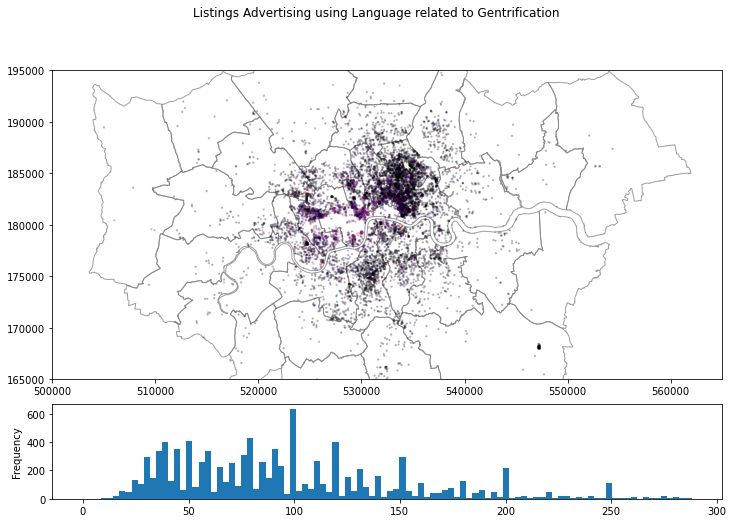

In [44]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='grey', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
gent.plot(markersize=2, column='price', cmap='magma', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
gent[gent.price<gent.price.quantile(0.95)].price.plot.hist(bins=100, ax=ax2)
#ax2.set_ylim([0,10000])

plt.suptitle("Listings Advertising using Language related to Gentrification")
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

In [45]:
grouped_gent = gent.groupby('borough')['price'].agg(Count='count')

In [46]:
grouped_gent.head(33).sort_values(by=['Count'], ascending=False)

,Count
borough,
Hackney,1897
Tower Hamlets,1529
Islington,946
Westminster,939
Lambeth,795
Southwark,772
Camden,729
Kensington and Chelsea,558
Hammersmith and Fulham,377


## Spatial Autocorrelation of Gentrified Listings

### Data cleaning

In this part, we will only keep a few columns for analysis.

**First**, we will count the airbnb listings based on room types. The number of listings per borough will be standardised which would allow us for a comparison. Afterwards, PCA will be conducted to reduce the dimension of our room types.

**Second**, mean/median price of airbnb listings will be calculated which will be standardised as well

Once these procedures are completed, we will go on with spatial autocorrelation analysis.

In [47]:
# Merge gentrified airbnb data with London borough shapefile 
gent1 = pd.merge(gent, boros, how = 'left', on = 'NAME')

In [48]:
# drop repeated column
gent1.drop(columns = ['NAME', 'GSS_CODE_x'], inplace =True)

In [49]:
gent1.rename(columns = {'GSS_CODE_y': 'GSS_CODE'}, inplace = True)

In [50]:
# Check room types

pivot = gent1.groupby(['GSS_CODE','room_type']
    
    # listing_url is an unique identifier and 
    # that is why we count number of rooms based on it
        ).host_id.agg(Count='count').reset_index().pivot(
    index='GSS_CODE', columns=['room_type'], values=['Count'])

# there is no null value in our new data and all columns in correct data types
pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, E09000001 to E09000033
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   (Count, Entire home/apt)  33 non-null     int64
 1   (Count, Hotel room)       33 non-null     int64
 2   (Count, Private room)     33 non-null     int64
 3   (Count, Shared room)      33 non-null     int64
dtypes: int64(4)
memory usage: 1.3+ KB


In [51]:
# We can check that Entire home/apt and Private room
# are predominant
pivot.sum()

       room_type      
Count  Entire home/apt    6728
       Hotel room          149
       Private room       3567
       Shared room          41
dtype: int64

In [52]:
# drop insignificant room_type

pivot.columns = ['Entire home/apt','Hotel room','Private room','Shared room']
pivot.drop(columns = ['Hotel room', 'Shared room'], inplace = True)

In [53]:
# normalise count of listings

pivot_norm = pd.DataFrame(index=pivot.index)
for c in pivot.columns.to_list():
    # Power Transform
    # count to normalised values
    pivot_norm[c] = pts.fit_transform(pivot[c].to_numpy().reshape(-1,1))

pivot_norm.head()

,Entire home/apt,Private room
GSS_CODE,,
E09000001,-0.25,-1.16
E09000002,-1.14,-0.66
E09000003,-0.26,-0.19
E09000004,-1.72,-1.87
E09000005,0.55,0.58


In [54]:
# We only have two columns in our pivot_norm
# And 97.4% of these can be explained by pca component 1

pcomp = PCA(n_components= 2, random_state=42)
rd    = pcomp.fit_transform(pivot_norm)
print(f"The explained variance of each component is: {', '.join([f'{x*100:.2f}%' for x in pcomp.explained_variance_ratio_])}")
explained_variance = pcomp.explained_variance_ratio_

The explained variance of each component is: 97.39%, 2.61%


In [55]:
# we are only choosing first component
# I just kept these 1 col

airbnb_pca = pd.DataFrame(
    # rescaling data with minmax scaler
    # as we are interested in the first PCA component,
    # we specify it with rd[:,0]
                {'2019_Airbnb Component 1': mms.fit_transform(rd[:,0].reshape(-1,1)).reshape(1,-1)[0]},
                index=pivot.index)



# In case, you want to keep two cols
#airbnb_pca = pd.DataFrame(
    # rescaling data with minmax scaler
 #               {'2019_Airbnb Component 1': mms.fit_transform(rd[:,0].reshape(-1,1)).reshape(1,-1)[0], 
  #              '2019_Airbnb Component 2': mms.fit_transform(rd[:,1].reshape(-1,1)).reshape(1,-1)[0]},
   #             index=pivot.index)

airbnb_pca.head()

,2019_Airbnb Component 1
GSS_CODE,
E09000001,0.39
E09000002,0.50
E09000003,0.12
E09000004,1.00
E09000005,-0.32


In [56]:
# Add the airbnb_pca to the original gent1 file

# merge the data based on GSS_CODE
ldn_gss_idx = gent1.set_index('GSS_CODE')
rs = pd.merge(ldn_gss_idx, airbnb_pca, left_index=True, right_index = True)
len(rs)

10485

In [57]:
rs.head(n=1)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,property_type,room_type,minimum_nights,maximum_nights,borough,price,geometry_x,HECTARES,NONLD_AREA,ONS_INNER,geometry_y,2019_Airbnb Component 1
GSS_CODE,,,,,,,,,,,,,,,,,,,
E09000001,482178,Great St Paul's and City location,This listing is our own home and not a managed...,2176101,"London, England, United Kingdom",2,2,Apartment,Entire home/apt,3,14,City of London,140.00,POINT (532283.423 181370.784),314.94,24.55,T,"MULTIPOLYGON (((531145.100 180782.100, 531143....",0.39


In [58]:
# Create a new dataframe that contains
# GSS_CODE, PCA component1, geometry of each listing
new_gent = rs.reset_index().loc[:, ['GSS_CODE', '2019_Airbnb Component 1', 'geometry_x']].copy().set_index('GSS_CODE')


# Append median price from cleaned listings grouped by GSS_CODE
s1 = rs.groupby(by='GSS_CODE').price.agg('median')
# rescale median price by using minmaxscaler
new_gent['2019_median_price'] = pd.Series(np.squeeze(mms.fit_transform(s1.values.reshape(-1,1))), index=s1.index)

# Append mean price from cleaned listings grouped by GSS_CODE
s2 = rs.groupby(by='GSS_CODE').price.agg('mean')
# rescale mean price by using minmaxscaler
new_gent['2019_mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2.values.reshape(-1,1))), index=s2.index)

new_gent.rename(columns = {'geometry_x': 'geometry'}, inplace = True)
new_gent= new_gent[['2019_Airbnb Component 1', '2019_median_price',
                   '2019_mean_price', 'geometry']]

new_gent.head(n=1)
# cldf is a merged numeric data of census tract and airbnb data
#s2 = cleaned.groupby(by='MSOA11CD').price.agg('mean')
#cldf['mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2.values.reshape(-1,1))), index=s2.index)

#cldf.drop(columns=['Subregion','Borough'], inplace=True)

#cldf.head()

,2019_Airbnb Component 1,2019_median_price,2019_mean_price,geometry
GSS_CODE,,,,
E09000001,0.39,1.00,1.00,POINT (532283.423 181370.784)


## Local Moran's I

Steps we've taken until now:
- We have eliminated two insignificant room_types (hotel, shared room) based on their numbers.
- We have normalised our airbnb data using powertransformation.
- We have reduced our airbnb dimensions from 2 to 1. The representiveness of first PCA component is 97 %.
- We have rescaled average/median price by using minmaxcaler.

Steps to take:
- We have to calculate spatial lag of our variable of interest. As we are very much keen on the number of airbnb listings, we have to create a spatial lag of pca-version of airbnb listing count.

The codes are adjusted from [Spatial Autocorrelation Code](https://deepnote.com/@siew-sook-yan/Python-Global-and-Local-Morans-51c478c0-3b3a-42df-9aef-caff60da71f6).

### Packages

In [59]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pysal.viz import mapclassify
import pysal as ps
import numpy as np
import esda
from pysal.lib import weights
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
from esda.moran import Moran_Local
from giddy.directional import Rose
from pysal.lib import weights
import libpysal
import splot
from splot.giddy import dynamic_lisa_composite

In [60]:
new_gent

,2019_Airbnb Component 1,2019_median_price,2019_mean_price,geometry
GSS_CODE,,,,
E09000001,0.39,1.00,1.00,POINT (532283.423 181370.784)
E09000001,0.39,1.00,1.00,POINT (533220.531 180927.892)
E09000001,0.39,1.00,1.00,POINT (531044.008 181536.743)
E09000001,0.39,1.00,1.00,POINT (533513.129 181525.353)
E09000001,0.39,1.00,1.00,POINT (531938.056 181730.135)
...,...,...,...,...
E09000033,-0.65,1.00,0.40,POINT (525894.920 180890.257)
E09000033,-0.65,1.00,0.40,POINT (529708.865 181159.755)
E09000033,-0.65,1.00,0.40,POINT (526187.500 181018.800)


In [61]:
new_gent.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 10485 entries, E09000001 to E09000033
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   2019_Airbnb Component 1  10485 non-null  float64 
 1   2019_median_price        10485 non-null  float64 
 2   2019_mean_price          10485 non-null  float64 
 3   geometry                 10485 non-null  geometry
dtypes: float64(3), geometry(1)
memory usage: 667.6+ KB


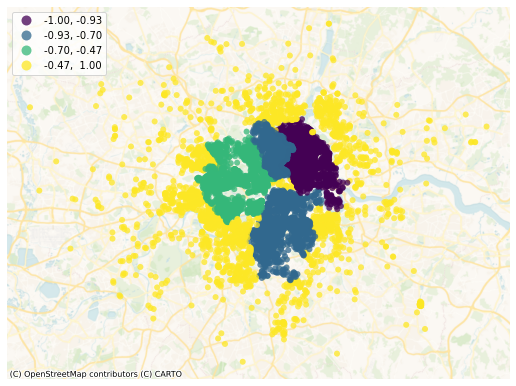

In [62]:
# Set up figure and a single axis
import contextily 


f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
new_gent.plot(
    column="2019_Airbnb Component 1",
    cmap="viridis",
    scheme="quantiles",
    k=4,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=new_gent.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();

In [63]:
# 30 listings in one neighbourhood can be thought of a sign that
# might indicate gentrification
df = new_gent.reset_index()
knn8 = weights.KNN.from_dataframe(df, k = 30)


# Row-standardization
knn8.transform = 'r'

In [64]:
# Spatial lag of our airbnb listings
df["w_2019_Airbnb Component 1"] = weights.spatial_lag.lag_spatial(
    knn8, df["2019_Airbnb Component 1"]
)
df.head(n=3)

,GSS_CODE,2019_Airbnb Component 1,2019_median_price,2019_mean_price,geometry,w_2019_Airbnb Component 1
0,E09000001,0.39,1.00,1.00,POINT (532283.423 181370.784),-0.10
1,E09000001,0.39,1.00,1.00,POINT (533220.531 180927.892),-0.05
2,E09000001,0.39,1.00,1.00,POINT (531044.008 181536.743),-0.33


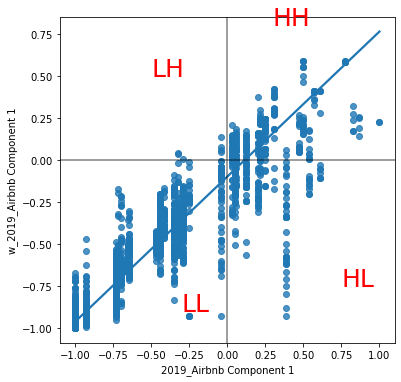

In [65]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x= "2019_Airbnb Component 1", y="w_2019_Airbnb Component 1", data=df, ci=None
);

# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(0.3, 0.8, "HH", fontsize=25, c="r")
plt.text(0.75, -0.75, "HL", fontsize=25, c="r")
plt.text(-0.5, 0.5, "LH", fontsize=25, c="r")
plt.text(-0.3, -0.9, "LL", fontsize=25, c="r")
# Display
plt.show()

Using standardized values, we can immediately divide each variable 

The airbnb pca component, and its spatial lag in two groups: 

those with above-average airbnb listings, which have positive standardized values;


those with below-average airbnb listings, which have negative standardized values;

In [66]:
# Local Moran's I
lisa_19 = esda.Moran_Local(df['2019_Airbnb Component 1'], knn8, seed = 42)

We need to pass the variable of interest — Airbnb PCA Component 1 in this context — 

and the spatial weights that describe the neighborhood relations between the different areas that make up the dataset. 

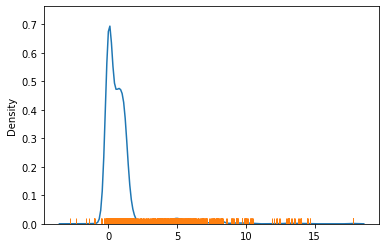

In [67]:
# Draw KDE line
ax = sns.kdeplot(lisa_19.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
sns.rugplot(lisa_19.Is, ax=ax);

The firgure shows a positively skewed distribution of local Moran'I statistics.

This indicates that most of Moran's I statistics values are positive.

Hence, we need to bear in mind that the high positive values arise from value similarity in space.

This can be due to either high values being next to high values or low values next to low values.

In other words, **Positive Autocorrelation**

But local Moran's I cannot distinguish which one it is between two.

### Choropleth plots of local Moran's I

In [68]:
# package
from splot import esda as esdaplot

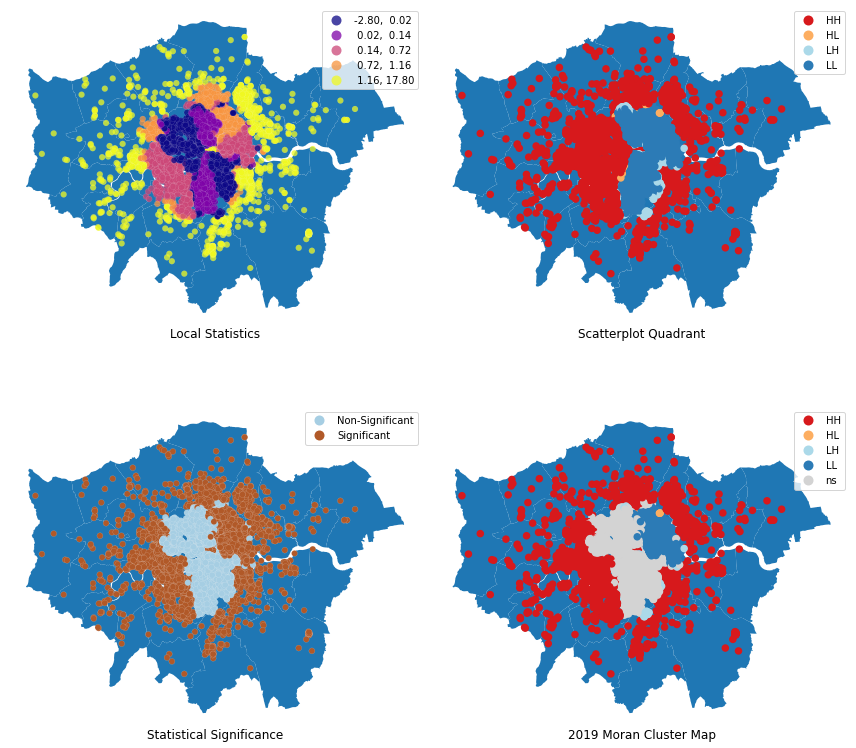

In [69]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# London borough map
boros.plot(ax = ax)
# Assign new column with local statistics on-the-fly
df.assign(
    Is=lisa_19.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)


# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# London borough map
boros.plot(ax = ax)
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa_19, df, p=1, ax=ax)


# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
# London borough map
boros.plot(ax = ax)
# Find out significant observations
labels = pd.Series(
    1 * (lisa_19.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=df.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
df.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)




# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# London borough map
boros.plot(ax = ax)
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_19, df, p=0.05, ax=ax)



# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "2019 Moran Cluster Map",
        ][i],
        y=-0.05,
    )
    

# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

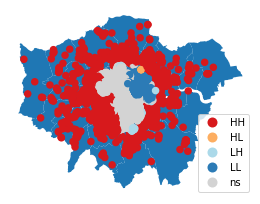

In [70]:
# Set up figure and axes
fig, ax1 = plt.subplots(figsize=(5, 3.5))
# London borough map
boros.plot(ax = ax1)
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_19, df, p=0.05, ax=ax1)
plt.show()

### Insight

The yellow and purple in the map on the upper left side show the largest magnitudes which can be either high or low values.

The map on the lower right corner shows the location of the LISA statistic in the quadrant of the Moran Scatter plot.

In [71]:
# count quadrant
# 1 means High-High quadrant
# 2 means Low-High quadrant
# 3 means Low-Low quadrant
# 4 means High-Low quadrant
counts = pd.value_counts(lisa_19.q)
counts

3    5814
1    4465
2     125
4      81
dtype: int64

### Insight
- HH (1) and LL (3) values are predominant.
- First two maps simply mapped the raw LISA value alongside the quadrant in which the local statistic resides. However, it didn't take into account statistical significance.
- The cluster map includes significance information alongside the quadrant and local statistic. Together, this map extracts significant observations -those that are highly unlikely to have come from pure chance- and plots them with a specific color depending on their quadrant category. 

In [72]:
# Statistically significant lisa statistics
(lisa_19.p_sim < 0.05).sum() * 100 / len(lisa_19.p_sim)

62.107773009060566

Nearly two-thirds of polygons that have degrees of local spatial association strong enough to reject the idea of pure chance.

Zone 3, Kensington and Chelsea, and Fulham areas indicate a high airbnb density.

While we can see clearly a low density of airbnb in East London, boroughs like Hackney, Islington and Tower Hamlets.


In [73]:
# Assign pseudo P-values to `db`
df["p-sim"] = lisa_19.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa_19.p_sim < 0.05)
# Assign significance flag to `db`
df["sig"] = sig

In [74]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa_19.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}

# Create column in `db` with labels for each polygon
df["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=df.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)

# Print first few rows
df["labels"].head()

0                 HH
1                 HH
2                 HH
3                 HL
4    Non-Significant
Name: labels, dtype: object

In [75]:
df.head(n=1)

,GSS_CODE,2019_Airbnb Component 1,2019_median_price,2019_mean_price,geometry,w_2019_Airbnb Component 1,p-sim,sig,labels
0,E09000001,0.39,1.00,1.00,POINT (532283.423 181370.784),-0.10,0.00,1,HH


In [76]:
# Filter HH and HL as they could be related to gentrification?
probable_gent = df.loc[(df['labels'] == 'HH') | (df['labels'] == 'HL') |
                              (df['labels'] == 'LH')]

In [77]:
probable_gent.GSS_CODE.value_counts()

E09000020    556
E09000013    377
E09000032    339
E09000005    240
E09000014    234
E09000023    199
E09000031    186
E09000025     90
E09000009     76
E09000006     74
E09000011     71
E09000008     69
E09000003     57
E09000024     48
E09000018     43
E09000007     40
E09000033     38
E09000027     32
E09000001     31
E09000002     20
E09000015     18
E09000010     18
E09000022     16
E09000028     16
E09000021     13
E09000026     11
E09000016      7
E09000019      6
E09000017      5
E09000029      4
E09000030      2
E09000004      2
Name: GSS_CODE, dtype: int64

### Interpretation of Local Moran's I
- Areas labelled as HL or LH can be thought of boroughs under gentrification threats.
- Areas labelled as HH are already highly gentrified.
- Kensington and Chelsea, Hammersmith and Fulham, and Wandsworth were top 3 boroughs with respect to gentrification
- HH are places where airbnbs are already densely gentrified
- HL means high values are surrounded by low values so this might tell us that some areas are under airbnb's expansion.
- LH means low values are surrounded by high values so we could think these are the areas under gentrification?

### NLP Basics: Filtering for Gentrification Terms
(Matt)

### Based on this regex, we can see that most airbnbs that use terms associated with gentrification in their description are located in Hackney.

In [78]:
kc = gdf[gdf.borough.str.contains(r'Kensington and Chelsea', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {kc.shape[0]:,} listings in the cleaned geodataset for listings in Kensington and Chelsea")

Camden = gdf[gdf.borough.str.contains(r'Camden', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {Camden.shape[0]:,} listings in the cleaned geodataset for listings in Camden")

hack = gdf[gdf.borough.str.contains(r'Hackney', regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {hack.shape[0]:,} listings in the cleaned geodataset for listings in Hackney")

Found 6,018 listings in the cleaned geodataset for listings in Kensington and Chelsea
Found 5,972 listings in the cleaned geodataset for listings in Camden
Found 6,276 listings in the cleaned geodataset for listings in Hackney


### Exporting Files
Here, I export the listings as geofeather to make them more useable (read take up less memory). However, for each, I will remove the geometry because that is not preserved in the process of writing to a feather

In [79]:
# #all cleaned listings
# geo_listings2022.drop(axis=1, columns=['geometry']).to_feather('full_2022listingsclean')

In [80]:
#all cleaned listings for this dataset (specific fields)
gdf2.drop(axis=1, columns=['geometry'])
gdf2.to_feather('listings19')

NameError: name 'gdf2' is not defined

In [ ]:
#gentrification listings
gent.drop(axis=1,columns=['geometry'])
gent.to_feather('listings19_gentrification')

In [ ]:
#kc listings
kc.drop(axis=1,columns=['geometry'])
kc.to_feather('listings19_kensington_chelsea')

In [ ]:
#camden listings
Camden.drop(axis=1,columns=['geometry'])
Camden.to_feather('listings19_camden')

In [ ]:
#hackney listings
hack.drop(axis=1, columns=['geometry'])
hack.to_feather('listings19_hackney')